In [1]:
cd '/home/dpirvu/axion'

/home/dpirvu/axion
The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import os,sys

print(sys.path)

#sys.path.remove('/home/dpirvu/DarkPhoton/hmvec-master')
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')

sys.path.append('/home/dpirvu/axion/hmvec-master/')
sys.path.append('/home/dpirvu/python_stuff/')

print(sys.path)

import hmvec as hm

from plotting import *
from compute_power_spectra import *
from params import *

%matplotlib inline

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


['/home/dpirvu/axion', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython']
['/home/dpirvu/axion', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/axion/hmvec-master/', '/home/dpirvu/python_stuff/']


In [ ]:
def beautify(ax, ttl=None, bb=None):
    try:
        len(ax)
    except:
        ax = np.array([ax])
    for ai, aa in enumerate(ax.flatten()):
        aa.grid(which='both', ls=':', color='lightgray', alpha=0.7)
        aa.tick_params(direction='in', which='both', top=True, right=True)
        #aa.ticklabel_format(axis='both', style='scientific', scilimits=[0.,0.])
        aa.xaxis.set_label_coords(0.5, -0.15)
        aa.yaxis.set_label_coords(-0.15, 0.5)
        aa.xaxis.label.set_color('k')
        aa.yaxis.label.set_color('k')
        aa.tick_params(axis='x', colors='k')
        aa.tick_params(axis='y', colors='k')
        aa.tick_params(direction='in', which='both', bottom=None, left=None, top=None, right=None)
        aa.spines['left'].set_color('k')
        aa.spines['right'].set_color('k')
        aa.spines['top'].set_color('k')
        aa.spines['bottom'].set_color('k')
        aa.legend(title=ttl, bbox_to_anchor=bb, frameon=False, handlelength=1.5, labelspacing=0.3, columnspacing=0.6)
    return ax


In [3]:
ellMax0 = 9600
ellMaxList = [9500]
ellMax = ellMaxList[0]
ells = np.arange(ellMax0)

getgas = True
dictmasses = dictKey[::3]; print(dictmasses)
model = modelParams
rscale = False

allcols = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
cych = cycle(allcols)

hlil = 0.6766
mMin = 7e8/hlil
mMax = 1e17

zMin = 0.005
zMax = 4.

nZs  = 100
nMs  = 100
#ms  = np.geomspace(1e11,1e17, nMs)                 # masses
ms  = np.geomspace(mMin,mMax, nMs)                 # masses
zs  = np.linspace(zMin, zMax, nZs)                 # redshifts
ks  = np.geomspace(1e-4, 1e3, 1001)               # wavenumbers

[1.4e-13 1.7e-13 2.2e-13 2.8e-13 3.4e-13 4.0e-13 4.6e-13 5.2e-13 5.8e-13
 6.4e-13 7.0e-13 8.0e-13 9.0e-13 1.0e-12 2.0e-12 3.0e-12 4.0e-12 5.0e-12
 6.0e-12 7.5e-12 9.0e-12 1.5e-11]


In [4]:
# Halo Model
unWISEcol = 'blue'
pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_0.txt"

hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', unwise_color=unWISEcol)

hod_name = "unWISE"+unWISEcol
hcos.add_hod(name=hod_name)

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)
dvols  = get_volume_conv(chis, Hz)

print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax0, :]
lensedCMB[0,0]= TCMB**2.

Importing base CMB PS and adding T monopole.


In [5]:
dvols     = get_volume_conv(chis, Hz)
dndz_data = np.transpose(np.loadtxt("./hmvec-master/data/blue.txt", dtype=float))
dndz      = np.interp(zs, dndz_data[0,:], dndz_data[1,:])
N_gtot    = np.trapz(dndz, zs, axis=0)
W_g       = dndz/N_gtot

Ncs  = hcos.hods[hod_name]['Nc']
Nss  = hcos.hods[hod_name]['Ns']
ngal = hcos.hods[hod_name]['ngal']
hod, uc, us = hcos._get_hod_common(hod_name)

uk_g   = (Ncs[None,:,None] + us*Nss[None,:,None]) / ngal[:,None,None]
uk_gsq = (2.*us*Nss[None,:,None] + us**2.*Nss[None,:,None]**2.) / ngal[:,None,None]**2.


In [6]:
uell_profile, uellsq_profile = np.zeros((2, len(zs), len(ms), len(ells)))
Pzell = np.zeros((len(zs), len(ells)))

f = interp2d(ks, zs, hcos.Pzk, bounds_error=True)     
for ii, ell in enumerate(ells):
    kevals = (ell+0.5)/chis
    interpolated = si.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], kevals, zs)[0]
    Pzell[:, ii] = interpolated

for mi, mm in enumerate(ms):
    f = interp2d(ks, zs, uk_g[:,mi,:], bounds_error=True)     
    for ii, ell in enumerate(ells):
        kevals = (ell+0.5)/chis
        interpolated = si.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], kevals, zs)[0]
        uell_profile[:, mi, ii] = interpolated

    f = interp2d(ks, zs, uk_gsq[:,mi,:], bounds_error=True)     
    for ii, ell in enumerate(ells):
        kevals = (ell+0.5)/chis
        interpolated = si.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], kevals, zs)[0]
        uellsq_profile[:, mi, ii] = interpolated


In [7]:
# Construct galaxy autocorrelation
zell_g = (W_g/dvols)[:,None,None] * uell_profile

intzell = (W_g[:,None]/dvols[:,None])**2. * np.trapz(nzm[...,None] * uellsq_profile, ms, axis=1)
Cell_gg_1h = np.trapz(dvols[:,None] * intzell, zs, axis=0)

intzell = W_g[:,None]/dvols[:,None] * np.trapz(nzm[...,None] * biases[...,None] * uell_profile, ms, axis=1)
Cell_gg_2h = np.trapz(dvols[:,None] * np.abs(intzell)**2. * Pzell, zs, axis=0)

Cell_gg_tot = Cell_gg_1h + Cell_gg_2h
# unWISE blue Cell^gg

In [8]:
def get_Cell_galaxy_cross_tau(zell_tau, zell_g, zMax):
    ''' Construct galaxy tau screening cross correlation '''
    ells = np.arange(ellMax)

    nZs  = 100
    nMs  = 100

    hlil = 0.6766
    mMin = 7e8/hlil
    mMax = 1e17

    msgal  = np.geomspace(7e8/hlil,1e17, nMs)            # masses
    zsgal  = np.linspace(0.005, 4., nZs)                 # redshifts

    mstau  = np.geomspace(1e11,1e17,nMs)               # masses
    zstau  = np.linspace(0.005, zMax, nZs)              # redshifts

    msnew = np.geomspace(1e11,1e17,nMs)
    zell_tau_new, zell_g_new = np.zeros((2, nZs, nMs, len(ells)))

    if zMax >= 4.:
        zsnew = np.linspace(0.005, 4., nZs)
        for li, ell in enumerate(ells):
            gf = interp2d(zsgal, msgal, zell_g[:,:,li].T, kind='linear')     
            zell_g_new[:, :, li] = gf(zsnew, msnew).T

            tf = interp2d(zstau, mstau, zell_tau[:,:,li].T, kind='linear')     
            zell_tau_new[:, :, li] = tf(zsnew, msnew).T

    else:
        zsnew = np.linspace(0.005, zMax, nZs)
        for li, ell in enumerate(ells):
            gf = interp2d(zsgal, msgal, zell_g[:,:,li].T, kind='linear')     
            zell_g_new[:, :, li] = gf(zsnew, msnew).T

            tf = interp2d(zstau, mstau, zell_tau[:,:,li].T, kind='linear')     
            zell_tau_new[:, :, li] = tf(zsnew, msnew).T

    if False:
        testind = 21
        plt.plot(msgal, zell_g[testind, :, 100], 'bo', ms=2)
        a1 = np.argmin(np.abs(zsnew - zsgal[testind]))
        print('a1', a1, zsnew[a1], zsgal[testind])
        plt.plot(msnew, zell_g_new[a1, :, 100], 'ro', ms=1); plt.xscale('log'); plt.yscale('log'); plt.show()

        plt.plot(zsgal, zell_g[:, testind, 100], 'bo', ms=2)
        a2 = np.argmin(np.abs(msnew - msgal[testind]))
        print('a2', a2, msnew[a2], msgal[testind])
        plt.plot(zsnew, zell_g_new[:, a2, 100], 'ro', ms=1); plt.yscale('log'); plt.show()

        plt.plot(mstau, zell_tau[testind, :, 100], 'bo', ms=2)
        a3 = np.argmin(np.abs(zsnew - zstau[testind]))
        print('a3', a3, zsnew[a3], zstau[testind])
        plt.plot(msnew, zell_tau_new[a3, :, 100], 'ro', ms=1); plt.xscale('log'); plt.yscale('log'); plt.show()

        plt.plot(zstau, zell_tau[:, testind, 100], 'bo', ms=2)
        a4 = np.argmin(np.abs(msnew - mstau[testind]))
        print('a4', a4, msnew[a4], mstau[testind])
        plt.plot(zsnew, zell_tau_new[:, a4, 100], 'ro', ms=1); plt.yscale('log'); plt.show()

    ##### Halo Model
    zs = zsnew
    ms = msnew

    hcos = hm.HaloModel(zs=zs, ks=ks, ms=ms, mass_function='tinker', mdef='vir', concmode='BHATTACHARYA')
    print(hm.default_params['H0'])
    print(hcos.conc)

    chis     = hcos.comoving_radial_distance(zs)
    rvirs    = hcos.rvir(ms[None,:],zs[:,None])
    cs       = hcos.concentration()
    Hz       = hcos.h_of_z(zs)
    nzm      = hcos.get_nzm()
    biases   = hcos.get_bh()
    dvols = get_volume_conv(chis, Hz)

    ff = interp2d(ks, zs, hcos.Pzk, bounds_error=True)     
    for ii, ell in enumerate(ells):
        kevals = (ell+0.5)/chis
        interpolated = si.dfitpack.bispeu(ff.tck[0], ff.tck[1], ff.tck[2], ff.tck[3], ff.tck[4], kevals, zs)[0]
        Pzell[:, ii] = interpolated

    int_zell_taug = np.trapz(nzm[...,None] * zell_tau_new * zell_g_new, ms, axis=1)

    int_zell_tau = np.trapz(nzm[...,None] * biases[...,None] * zell_tau_new, ms, axis=1)
    int_zell_g   = np.trapz(nzm[...,None] * biases[...,None] * zell_g_new,   ms, axis=1)

    Cell_taug_1h = np.trapz(dvols[:,None] * int_zell_taug, zs, axis=0)
    Cell_taug_2h = np.trapz(dvols[:,None] * int_zell_tau * int_zell_g * Pzell, zs, axis=0)

    Cell_taug_tot = (Cell_taug_1h + Cell_taug_2h)
    return Cell_taug_1h, Cell_taug_2h, Cell_taug_tot

In [9]:
getgas = True
dictmasses = dictKey
model = modelParams
rscale = False

ztype = [1.9]
zreio = 1.9

fsky = [0.4, 0.4]
pick_prof = True

name = 'battagliaAGN'
rscale = False

In [12]:
if False:
    ells = np.arange(ellMax)
    datagalgal = [ells, Cell_gg_1h[ells], Cell_gg_2h[ells], Cell_gg_tot[ells]]
    np.save(cl_data_galgal_path(nZs, zMin, zMax, ellMax, rscale), datagalgal)

    for mind, MA in enumerate(dictmasses):
        for zind, ztest in enumerate(ztype):
            zMin, zMax, rMin, rMax = chooseModel(MA, model)
            zMax = min(zreio, zMax)
            print('zmax', zMax)

            path2do = cl_data_galtau_path(MA, nZs, zMin, zMax, ellMax, rscale)
            if os.path.exists(path2do):
                continue
            else:
                print('Doing MA=', MA)

            data = import_data(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
            rcross, prob, avtau, dtaudz, uell0, Cell1H, Cell2H, CMBDP  = data

            screeningProbell = prob[None,...] * uell0
            zell_tau = (np.sqrt((4.*np.pi)/(2*ells+1))[:,None,None] * screeningProbell).transpose(1,2,0)

            Cell_taug_1h, Cell_taug_2h, Cell_taug_tot = get_Cell_galaxy_cross_tau(zell_tau, zell_g, zMax)
            np.save(cl_data_galtau_path(MA, nZs, zMin, zMax, ellMax, rscale), [ells, Cell_taug_tot])

    del rcross, prob, avtau, dtaudz, uell0, Cell1H, Cell2H, CMBDP, screeningProbell
    del Cell_taug_1h, Cell_taug_2h, Cell_taug_tot


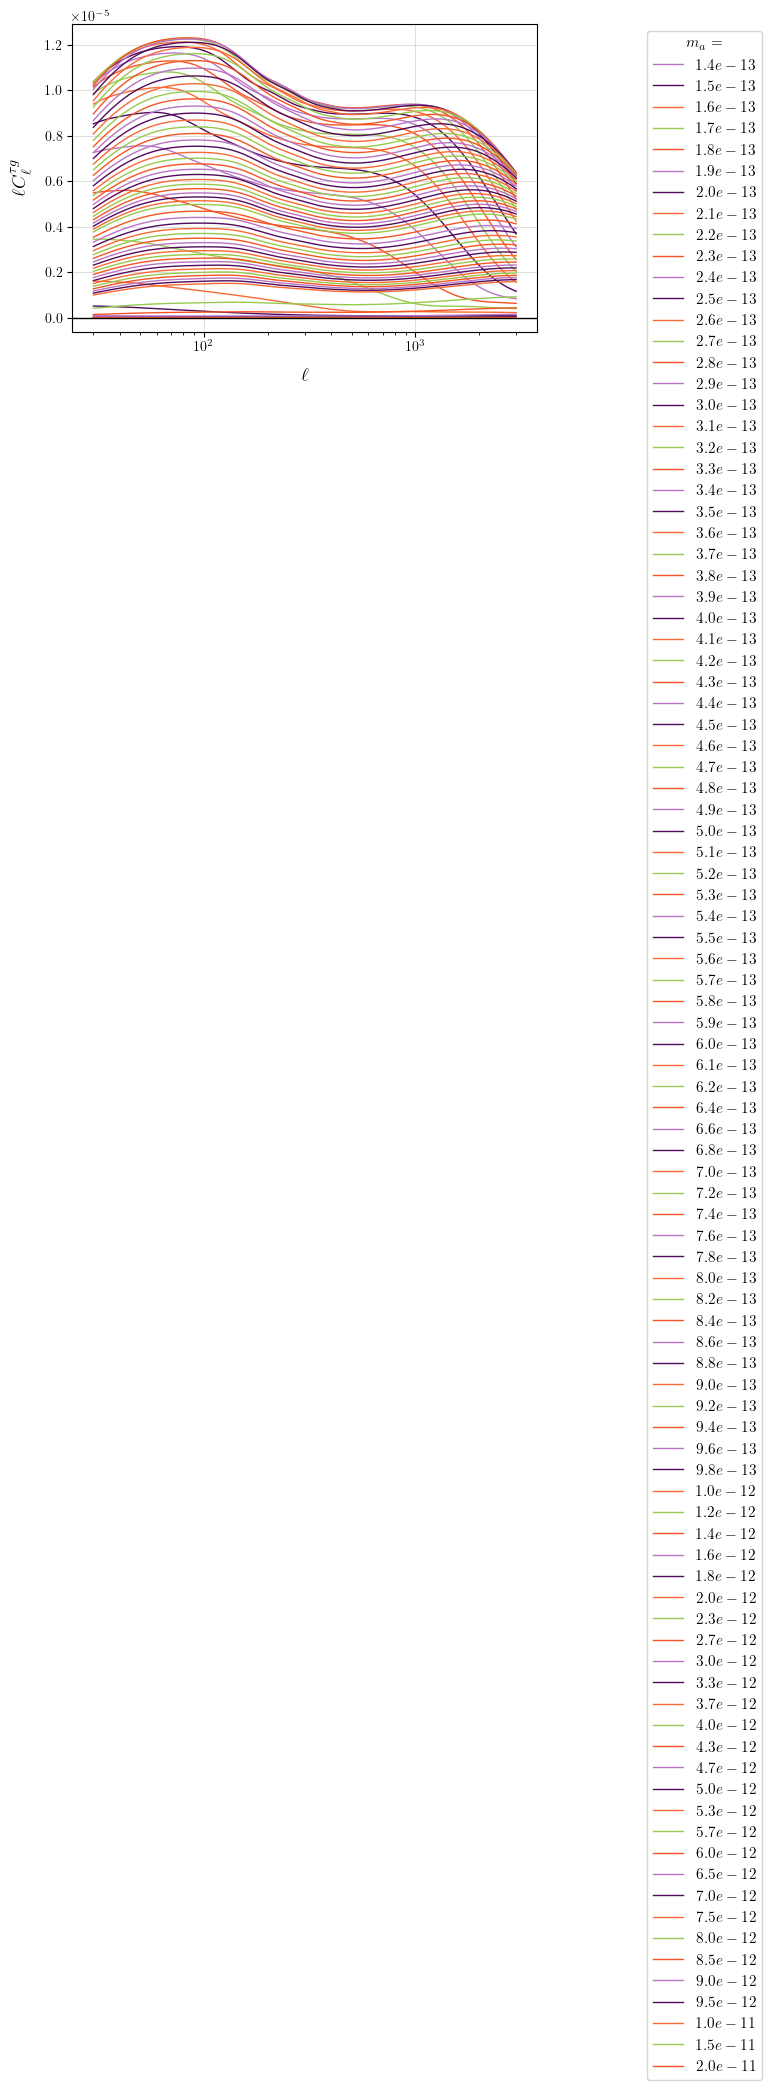

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

varep = 4e-20

for mind, MA in enumerate(dictmasses):
    ells, Cell_taug_tot = np.load(cl_data_galtau_path(MA, nZs, zMin, zMax, ellMax, rscale))

    mm, mmm = 30, 3000
    plt.plot(ells[mm:mmm], ells[mm:mmm] * varep**2. * Cell_taug_tot[mm:mmm], ls='-', lw=1, label=r'${:.1e}$'.format(MA))

plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell C_\ell^{\tau g}$')
plt.axhline(0, color='k', linewidth=1.)
plt.grid(True, alpha=0.4)
plt.legend(title=r'$m_a =$', bbox_to_anchor=(1.5,1.))
plt.show()

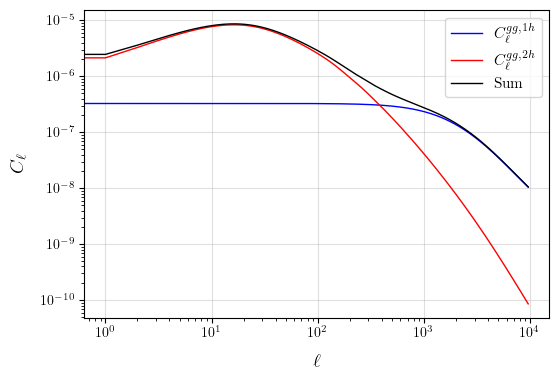

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.plot(ells, Cell_gg_1h, ls='-', lw=1, color='b', label=r'$C_\ell^{gg,1h}$')
plt.plot(ells, Cell_gg_2h, ls='-', lw=1, color='r', label=r'$C_\ell^{gg,2h}$')
plt.plot(ells, Cell_gg_tot, ls='-', lw=1, color='k', label=r'$\rm Sum$')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.axhline(0, color='k', linewidth=1.)
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()